In [1]:
import tensorflow as tf
# tf.enable_eager_execution()
import src.infovae as infovae
from src.utils import input_fn

import numpy as np
import matplotlib.pyplot as plt

/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
ds = input_fn(50)
iterator = ds.make_one_shot_iterator()
img, t = iterator.get_next()
init_op = iterator.make_initializer(ds)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
nn = infovae.InfoVAE(2, 16, 4)

In [4]:
emb = tf.layers.flatten(infovae.reparameterise(nn.encoder(img), 2, 0.0))

In [5]:
saver = tf.train.Saver()
model_path = '/media/act65/640a4914-fb27-4b69-acc6-2a2d569c900b/cantract-infovae/2dims/0/'

def run(x, n):  
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint(model_path))
        results = [sess.run(x) for _ in range(n)]
    return tuple(np.vstack(r) for r in zip(*results))

In [6]:
embeddings, labels = run([emb, t], 50)

INFO:tensorflow:Restoring parameters from /media/act65/640a4914-fb27-4b69-acc6-2a2d569c900b/cantract-infovae/2dims/0/infovae_saver.ckpt


In [7]:
embeddings.shape

(2500, 2)

In [8]:
def gaussian_kernel(x, emb, temp=1.0):
    x = np.expand_dims(x, 1)
    emb = np.expand_dims(emb, 0)
    return (1/np.sqrt(2*np.pi)) * np.exp(-0.5*np.sum((x-emb)**2, axis=2)/temp)

In [143]:
A = gaussian_kernel(embeddings, embeddings)
A -= np.diag(A[np.diag_indices(embeddings.shape[0])])

# A[np.abs(A) < 0.1] = 0

A.shape

(2500, 2500)

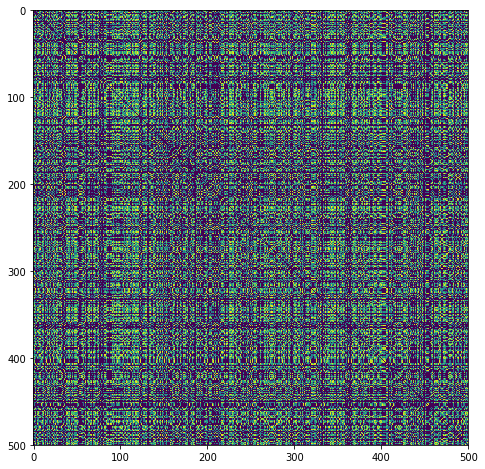

In [144]:
plt.figure(figsize=(16, 8))
plt.imshow(A[::5, ::5])

In [158]:
def graph_laplacian(A):
    D = np.diag(np.sum(A, axis=0))
    return D - A

def normalised_laplacian(A):
    D = np.diag(np.sum(A, axis=0)**(-0.5))
    return np.eye(embeddings.shape[0]) - np.dot(np.dot(D, A), D)  # the symmetric graph laplacian

In [159]:
L = graph_laplacian(A)
u, s, v = np.linalg.svd(L)
# want a multiscale density basis!?!?
# aka variable sized averages?
# so just smooth the laplacian!?



In [163]:
k = np.zeros([embeddings.shape[0], 1])
k[:10] += 1

np.dot(A, k)

array([[0.76499856],
       [0.48909101],
       [0.98843542],
       ...,
       [1.87294444],
       [1.92642964],
       [0.85598168]])

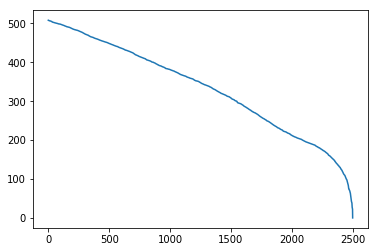

In [160]:
plt.plot(s)  # not what I expected...
# clipping the Aijs doesnt seem to effect this!?

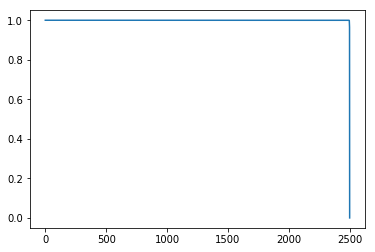

In [162]:
M = np.linalg.matrix_power(A, 5)
L = normalised_laplacian(M)
u, s, v = np.linalg.svd(L)
plt.plot(s)

<BarContainer object of 2500 artists>

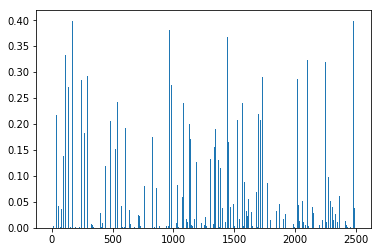

In [103]:
idx = np.random.randint(0, embeddings.shape[0])
x = embeddings[idx, :]  # an encoded image/aka embedding
g = gaussian_kernel(embeddings, x, temp=0.1)
# so this is a sparse basis!?
plt.bar(range(len(g)),g[:, 0])

<BarContainer object of 2500 artists>

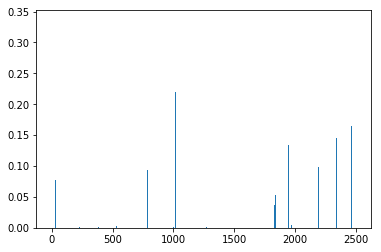

In [102]:
x = np.random.standard_normal((1, 2)) +1 # some encoded image
g = gaussian_kernel(embeddings, x, temp=0.1)
plt.bar(range(len(g)),g[:, 0])

In [107]:
def graph_convolution(g, filters, spectra):
    """
    Convole a graph signal with a set of filters using the basis provided.
    
    Want a multiscale representation.
    """
    g_spectra = np.dot(spectra, g)
    f_spectra = np.dot(spectra, filters)
    
    r = g_spectra * f_spectra
    
    return np.dot(spectra.T, r)

In [114]:
filters = np.random.random((2500, 10))
r = graph_convolution(g, filters, u)

In [115]:
r.shape

(2500, 10)